In [5]:
# Load jld files and analyze
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
components_data_path = '../selected_15_components_data.csv'
components_df = pd.read_csv(components_data_path)
component_ids = list(components_df['component_id'])

In [7]:
mean_components_proposed = np.zeros((15,51))
std_components_proposed = np.zeros((15,51))

# calulate survival stats from rewards data

for i in range(len(component_ids)):

    # load reward histories
    rewards = h5py.File(f"reward_histories_{component_ids[i]}.jld2", "r")
    reward_histories = np.int64(rewards['data'][:])
    survive_data = np.count_nonzero(reward_histories == 1, axis=0)/100.0
    mean_components_proposed[i,:] = np.mean(survive_data,axis=0)
    std_components_proposed[i,:] = np.std(survive_data,axis=0)

# average over the components
mean_overall_proposed = np.mean(mean_components_proposed,axis=0)
std_overall_proposed = np.std(std_components_proposed,axis=0)

# budgets
budgets = list(np.arange(51)*20)    

In [8]:
# load baseline stats

mean_components_baseline = np.load('baseline_survival_means.npy')
std_components_baseline = np.load('baseline_survival_stds.npy')

mean_overall_baseline = np.mean(mean_components_baseline, axis=0)
std_overall_baseline = np.mean(std_components_baseline, axis=0)

Text(0, 0.5, 'Time to Failure Ratio')

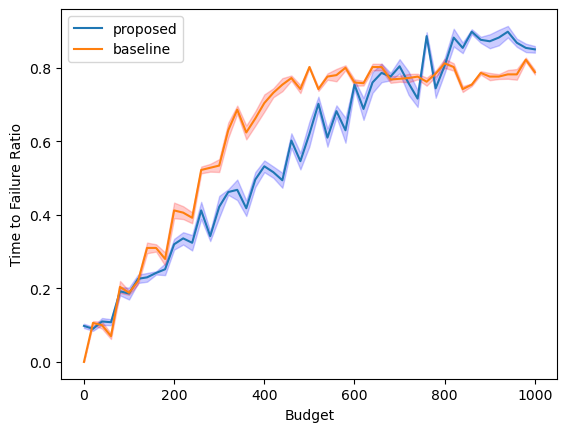

In [9]:
# component wise plotting
component_index = 14

conf_int_proposed = 1.96*std_components_proposed[component_index]/np.sqrt(len(budgets))
conf_int_baseline = 1.96*std_components_baseline[component_index]/np.sqrt(len(budgets))

plt.plot(budgets,mean_components_proposed[component_index], label='proposed')
plt.plot(budgets,mean_components_baseline[component_index], label='baseline')
plt.fill_between(budgets,(mean_components_proposed[component_index]-conf_int_proposed),(mean_components_proposed[component_index]+conf_int_proposed),color='b',alpha=.2)
plt.fill_between(budgets,(mean_components_baseline[component_index]-conf_int_baseline),(mean_components_baseline[component_index]+conf_int_baseline),color='r',alpha=.2)
plt.legend()
plt.xlabel('Budget')
plt.ylabel('Time to Failure Ratio')

Text(0, 0.5, 'Time to Failure Ratio')

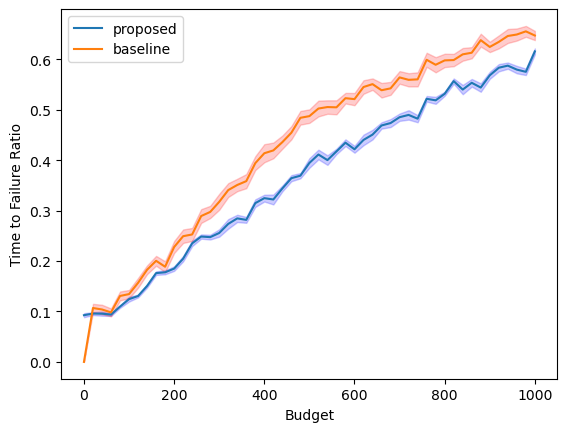

In [10]:
# overall results comparison

conf_int_proposed = 1.96*std_overall_proposed/np.sqrt(len(budgets))
conf_int_baseline = 1.96*std_overall_baseline/np.sqrt(len(budgets))
plt.plot(budgets,mean_overall_proposed,label='proposed')
plt.plot(budgets,mean_overall_baseline, label='baseline')
plt.fill_between(budgets,(mean_overall_proposed-conf_int_proposed),(mean_overall_proposed+conf_int_proposed),color='b',alpha=.2)
plt.fill_between(budgets,(mean_overall_baseline-conf_int_baseline),(mean_overall_baseline+conf_int_baseline),color='r',alpha=.2)
plt.xlabel('Budget')
plt.legend()
plt.ylabel('Time to Failure Ratio')

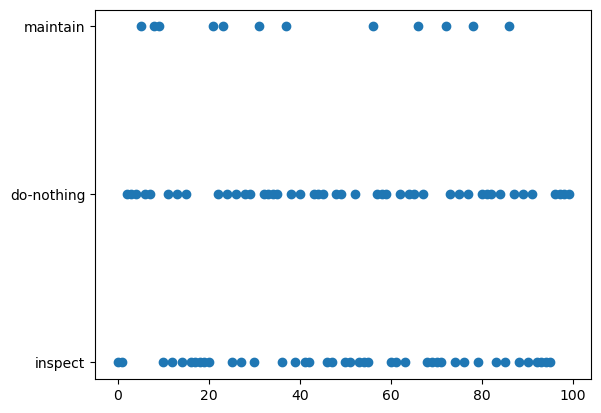

In [14]:
action_history = h5py.File("action_histories_5.jld2","r")
action_history = action_history['data'][:,0,50]
time = np.arange(0,100)
plt.scatter(time,action_history)

In [11]:
def visualize_history(state_history, action_history, replace_cost, inspect_cost, failure_condition=0):
        """
        Visualize the historic state of the component and the action taken
        """
        get_inspect_indices = [i for i in range(1,len(action_history)) if action_history[i] == 1]
        get_replace_indices = [i for i in range(1,len(action_history)) if action_history[i] == 2]
        get_inspect_states = [state_history[i] for i in get_inspect_indices]
        get_replace_states = [state_history[i] for i in get_replace_indices]

        plt.figure(figsize=(15,5))
        plt.plot(state_history, '.-', color='gray', linewidth=2, alpha=1.0,  label='component CI')
        plt.scatter(get_inspect_indices, get_inspect_states, marker='o', color='green', s=70, alpha=0.8, label='inspection')
        plt.scatter(get_replace_indices, get_replace_states, marker='o', color='red', s=70, alpha=0.8, label='replacement')
        plt.plot(failure_condition*np.ones(len(state_history)), 'k--', label='failure condition', linewidth=2.5, alpha=0.6)
        plt.xlim(0, len(state_history))
        plt.ylim(0, max(state_history)+10)
        plt.legend()
        plt.xlabel('time step', fontsize=18)
        plt.xticks(fontsize=14)
        plt.ylabel('condition index', fontsize=18)
        plt.yticks(fontsize=14)
        plt.legend(prop={'size': 14}, frameon=False)
        sns.despine(right=True, top=True)
        plt.title(f'CI History with Inspect Cost: {inspect_cost}, Replace Cost: {replace_cost}', fontsize=16)
        plt.tight_layout()
        plt.show()

78


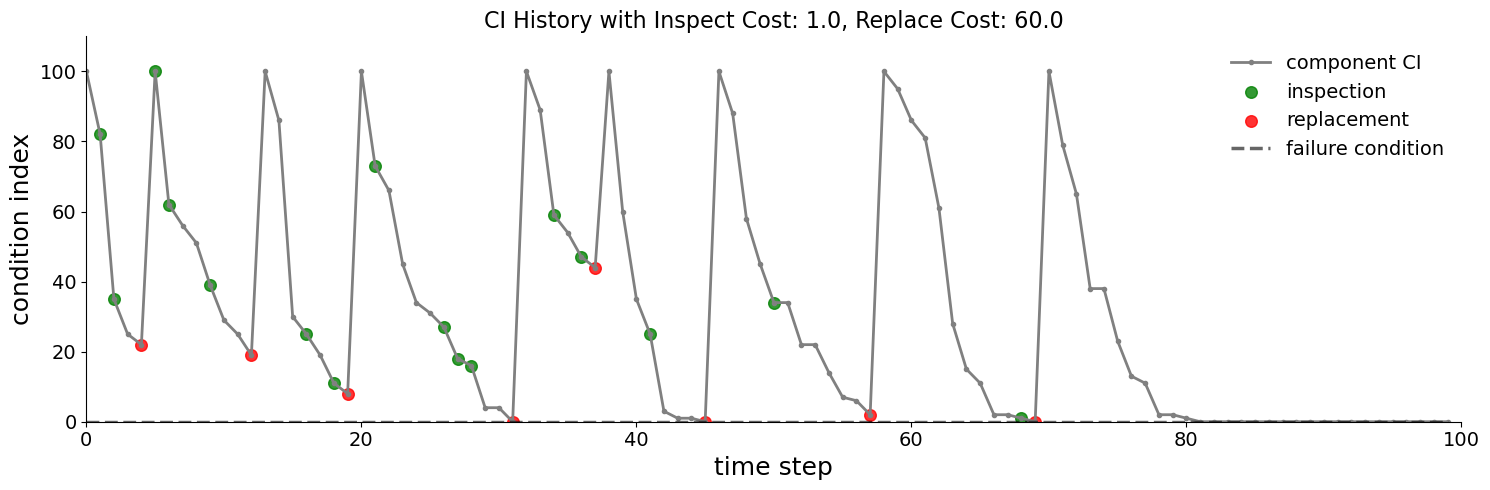

In [17]:
# load state and action histories for a component

action_histories = h5py.File("action_histories_test2_5.jld2","r")

# decode strings while avoiding b character
action_histories = action_histories['data'][:]
action_histories = action_histories.astype(str)

state_histories = h5py.File("state_histories_test2_5.jld2","r")
state_histories = state_histories['data'][:]

observation_histories = h5py.File("observation_histories_test2_5.jld2","r")
observation_histories = observation_histories['data'][:]

trial = 0
action_history_labels = action_histories[:,trial,1] 
action_history = np.zeros((100))

state_history_true = state_histories[:,trial,1]
state_history = np.zeros((100))

observation_history_true = observation_histories[:,trial,1]
observation_history = np.zeros((100))

for i in range(len(action_history)):
    if action_history_labels[i] == 'do-nothing':
        action_history[i] = 0
    elif action_history_labels[i] == 'inspect':
        action_history[i] = 1
    elif action_history_labels[i] == 'maintain':
        action_history[i] = 2

    if state_history_true[i][0] > 100 or state_history_true[i][0] < 0:
        state_history[i] = 0
    else:
        state_history[i] = state_history_true[i][0]

    if observation_history_true[i][0] > 100 or observation_history_true[i][0] < 0:
        observation_history[i] = 0
    else:
        observation_history[i] = observation_history_true[i][0]


budget_used = state_history_true[-1][1]
print(np.count_nonzero(state_history))


visualize_history(state_history, action_history, replace_cost=60.0, inspect_cost=1.0, failure_condition=0)